In [2]:
import numpy as np
import rasterio
from rasterio.plot import show #limite l'importation de la libairie
from rasterio.plot import show_hist #limite l'importation de la libairie
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy import fft
from scipy import ndimage

import rioxarray as rio
from rasterio.enums import Resampling


In [3]:
filename = '/home/francis/Documents/UQAR/Cours/GEO71021/data_exemple/serpentine_20210308_15min.csv'

bd = pd.read_csv(filename,sep = ',', header = 0)

format = '%Y-%m-%d %H:%M:%S' # spécifie le format dans lequel mon string va être pour créer le datetime

bd['datetime'] = pd.to_datetime(bd['Date'] + ' ' + bd['Time'], format=format) #nouvel colonne datetime
bd = bd.set_index(pd.DatetimeIndex(bd['datetime'])) # je set ma nouvelle datetime comme index
bd

,Date,Time,ValleyRecID,SW-IN,SW-OUT,LW-IN,LW-OUT,PAR-IN,PAR-OUT,AirTemp,...,SnowDepth,PrecipRate,PrecipTotal,BucketWeight,PluvioStatus,WS,WD,WG,BatVolt,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-13 13:00:09,2020-11-13,13:00:09,Valley,76.6,9.7,281.4,328.1,190.9,11.6,2.67,...,-0.2,0.0,483.97,807.0,0,0.6,65.1,2.1,14.29,2020-11-13 13:00:09
2020-11-13 13:15:09,2020-11-13,13:15:09,Valley,104.7,7.3,283.3,326.4,149.9,9.2,2.65,...,-0.2,0.0,483.97,807.0,0,0.1,144.0,1.1,14.30,2020-11-13 13:15:09
2020-11-13 13:30:09,2020-11-13,13:30:09,Valley,53.8,5.7,284.3,325.7,120.6,8.1,2.65,...,0.0,0.0,483.97,807.0,0,0.0,63.9,0.0,14.24,2020-11-13 13:30:09
2020-11-13 13:45:09,2020-11-13,13:45:09,Valley,60.8,5.5,284.1,324.6,117.9,7.2,2.54,...,0.0,0.0,483.97,807.0,0,0.0,270.0,0.0,14.26,2020-11-13 13:45:09
2020-11-13 14:00:09,2020-11-13,14:00:09,Valley,54.1,5.8,281.2,324.2,121.2,7.3,2.38,...,0.1,0.0,483.97,807.0,0,0.8,152.2,2.9,13.68,2020-11-13 14:00:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-08 09:00:09,2021-03-08,09:00:09,Valley,412.6,254.0,236.4,287.5,384.5,592.8,-7.74,...,103.8,0.0,27.45,1387.7,0,3.5,58.5,6.5,14.39,2021-03-08 09:00:09
2021-03-08 09:15:09,2021-03-08,09:15:09,Valley,414.8,355.8,250.0,298.7,718.8,816.7,-7.32,...,103.8,0.0,27.45,1387.7,0,4.3,77.2,7.9,14.28,2021-03-08 09:15:09
2021-03-08 09:30:09,2021-03-08,09:30:09,Valley,522.7,356.0,246.4,301.6,952.3,819.3,-6.74,...,103.8,0.0,27.45,1387.7,0,2.1,344.8,7.2,14.19,2021-03-08 09:30:09


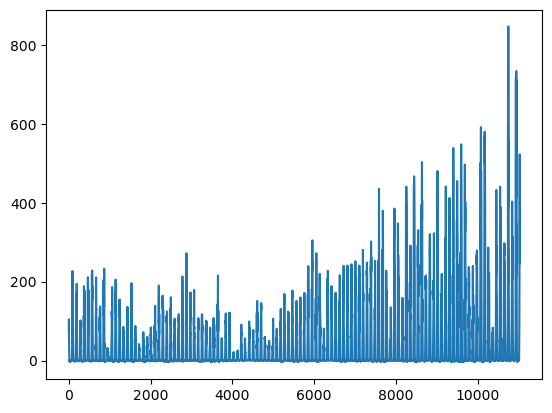

In [12]:
air_temp = np.array(bd['SW-IN'])
plt.plot(air_temp)

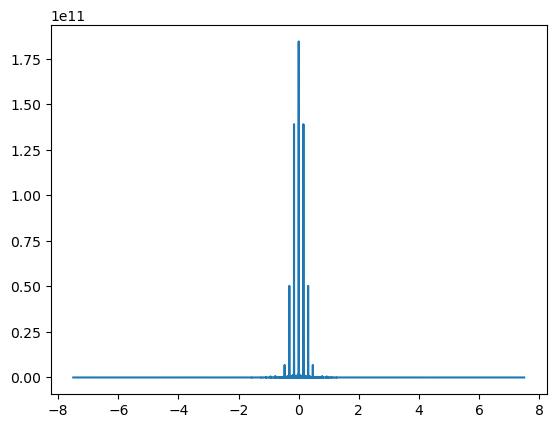

In [13]:
#air_temp = np.array(bd['AirTemp'])

spec_air = np.fft.fft(air_temp)
pspec_air = np.abs(spec_air)**2
N = np.size(air_temp)

time_step = 1/15
freqs = np.fft.fftfreq(pspec_air.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], pspec_air[idx])
#plt.show

/tmp/ipykernel_18671/2086639194.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(f**-1,pxx_den) # rebasculer en minute


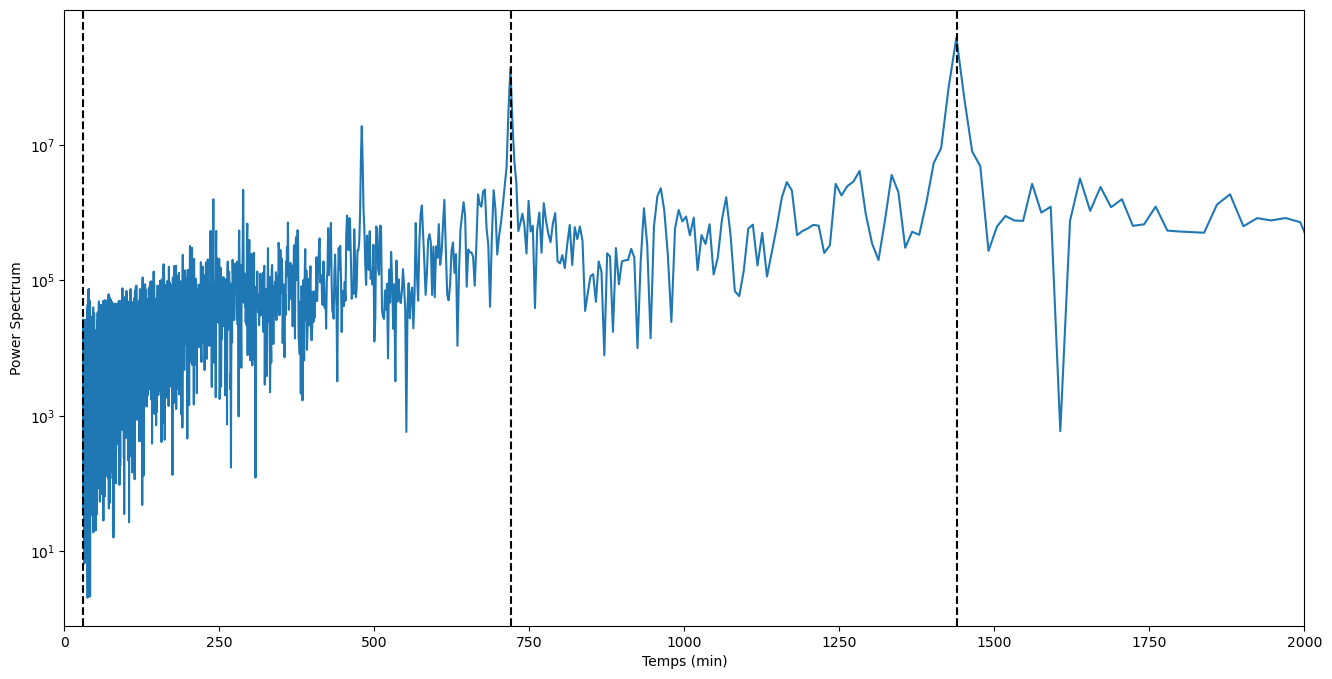

In [14]:
f,pxx_den = signal.periodogram(air_temp,1/15, scaling = 'density')
plt.figure(figsize = (16,8))
plt.semilogy(f**-1,pxx_den) # rebasculer en minute
#plt.ylim([10e2,10e9])
plt.xlim([0,2000])
plt.xlabel('Temps (min)')
plt.ylabel('Power Spectrum')
plt.axvline(x=15*2, color = 'black', linestyle = 'dashed')

plt.axvline(x=1440, color = 'black', linestyle = 'dashed')
plt.axvline(x=720, color = 'black', linestyle = 'dashed')
#plt.axvline(x=480, color = 'black', linestyle = 'dashed')

## Exemple avec un DEM d'hauteur de neige

resolution  0.018056900250032808
upscale_factor 0.036113800500065615
(1, 543, 548)
(0.5007824309649187, -0.5005053550847947)


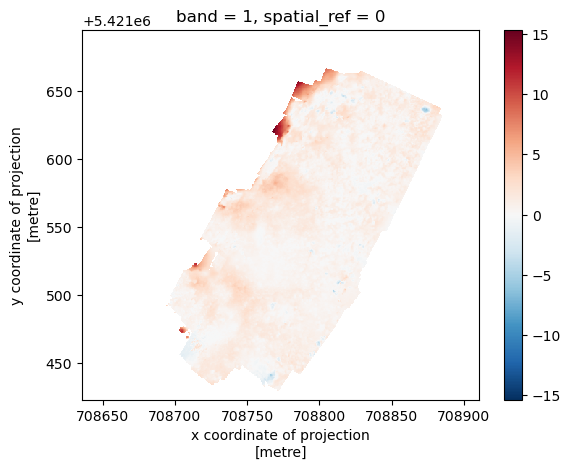

In [57]:
#raster = rasterio.open('/home/francis/Documents/programmation/Qgis/terrain_analysis/DTM_EP.tif',masked=True)
xdr = rio.open_rasterio('/home/francis/Documents/programmation/Qgis/terrain_analysis/snowdepth/epaule_20210317_snowdepth.tif',mask_and_scale = True)
res = xdr.rio.resolution()
# resample data to target shape
print('resolution ',res[0])
upscale_factor = res[0]/0.5 #on s'en va vers une résolution de 0.5m
print('upscale_factor',upscale_factor)
new_width = int(xdr.rio.width * upscale_factor)
new_height = int(xdr.rio.height * upscale_factor)

xdr_resamp = xdr.rio.reproject(xdr.rio.crs, shape = (new_height, new_width), resampling = Resampling.bilinear)
print(xdr_resamp.shape)
print(xdr_resamp.rio.resolution())
xdr_resamp.plot()
res = xdr_resamp.rio.resolution()
x = res[0]
y = res[1]

In [17]:
print(raster.read(1))

NameError: name 'raster' is not defined

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


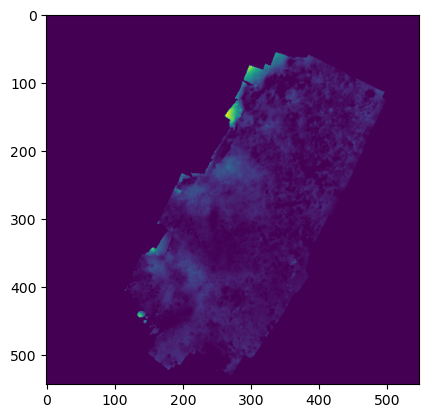

In [58]:
arr = np.array(xdr_resamp[0])
#arr=arr.astype('float')
arr[arr < 0] = 0
arr[np.isnan(arr)] = 0
plt.imshow(arr, cmap= 'viridis')
print(arr)

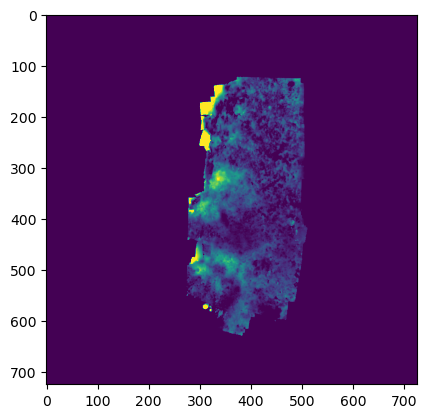

In [59]:
r_arr = ndimage.rotate(arr,25)
plt.imshow(r_arr, cmap= 'viridis',vmin = 0, vmax = 5)

[[-1.3094513e-01  9.6121989e-02 -5.5394894e-01 ...  1.9993675e+00
   1.6722381e+00  1.5440894e+00]
 [ 2.2144744e+00 -9.2439193e-01  1.6654665e+00 ...  1.4814920e+00
   1.6116017e+00  1.6322526e+00]
 [ 8.3575697e+00  5.6995864e+00  6.7442451e+00 ...  4.9047694e-01
   7.7824312e-01  7.7408671e-01]
 ...
 [ 6.8183517e-01  6.0148162e-01  4.8214731e-01 ...  8.1237233e-01
  -1.0631707e-01  2.9112821e-02]
 [ 7.6097250e-01  5.4391479e-01  3.9737269e-01 ...  3.9457303e-01
  -8.1019377e-04 -1.0139115e-02]
 [ 6.2504977e-01  5.2191734e-01  3.3325475e-01 ... -5.7610892e-02
  -4.7385138e-02  6.9707772e-03]]


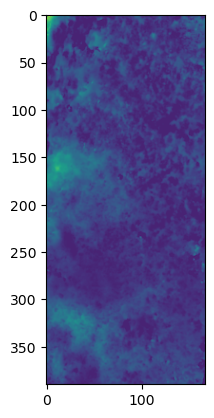

In [60]:
cropped= r_arr[160:550, 325:492]
plt.imshow(cropped, cmap= 'viridis')
print(cropped)

## Test avec un transect (colonne)

390


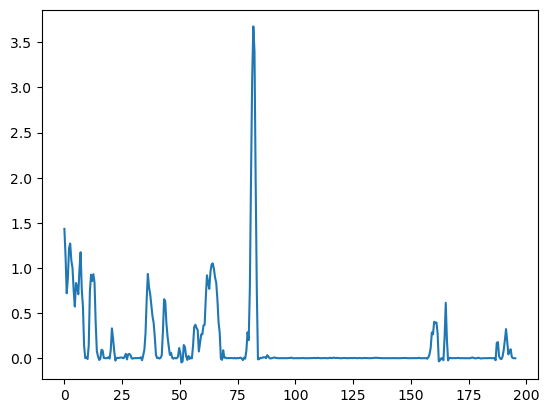

In [32]:
ty = cropped[:,25]
print(len(ty))
posi = np.linspace(0,len(ty), len(ty))*x
plt.plot(posi, ty)

/tmp/ipykernel_18671/582867147.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(f**-1,pxx_den) # rebasculer en minute


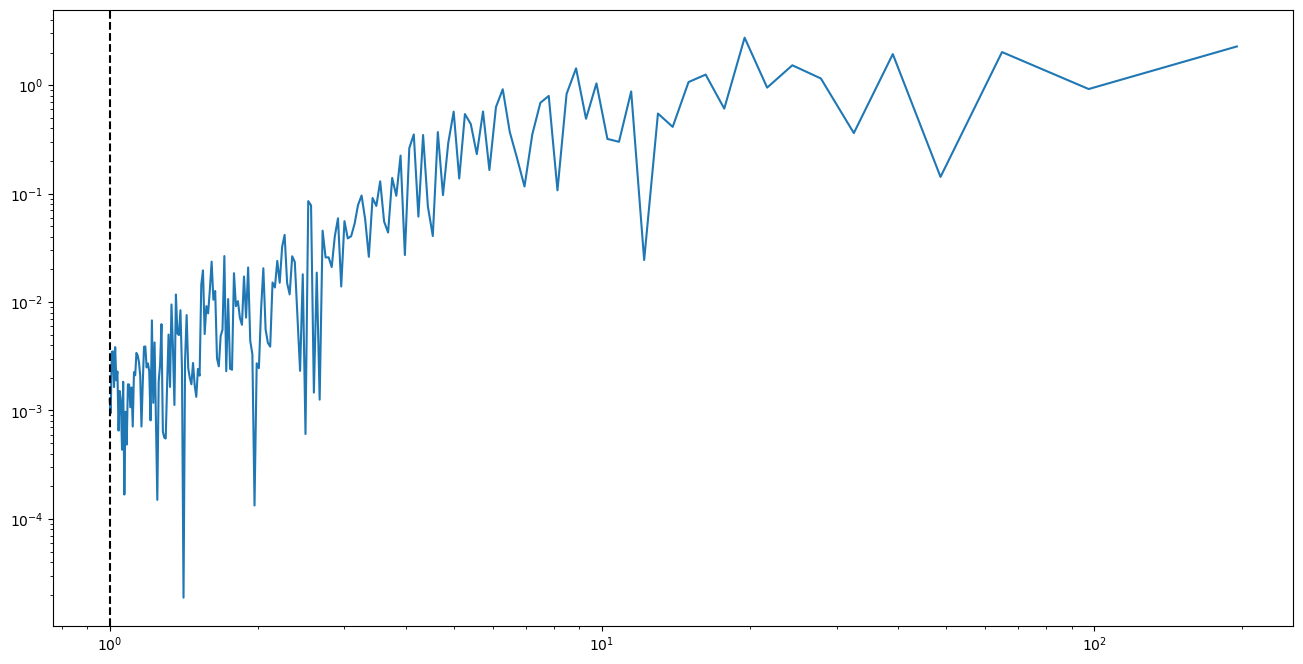

In [33]:
f,pxx_den = signal.periodogram(ty,1/0.5, scaling = 'density')
plt.figure(figsize = (16,8))
plt.semilogy(f**-1,pxx_den) # rebasculer en minute
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
#plt.xlim(0,40)
plt.xscale('log')

390
0.5004666578872813
(390,)


/tmp/ipykernel_18671/4169333070.py:13: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_y)
/tmp/ipykernel_18671/4169333070.py:19: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1,ps_y)
/tmp/ipykernel_18671/4169333070.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,100)
/tmp/ipykernel_18671/4169333070.py:27: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(freq_shift**-1,ps_y)


(0.0, 100.0)

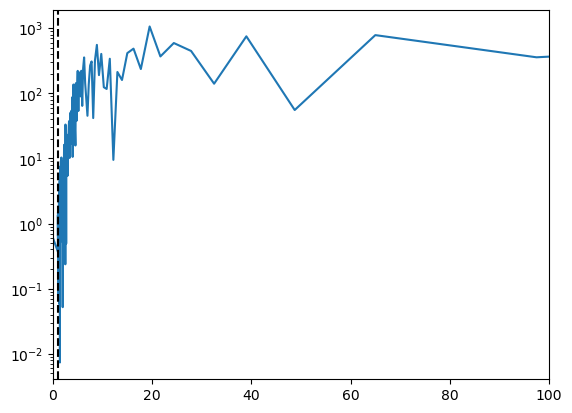

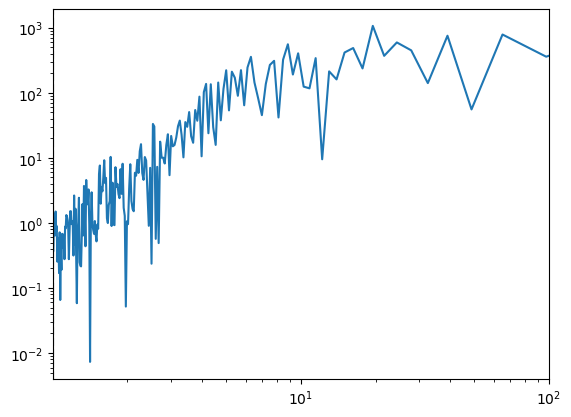

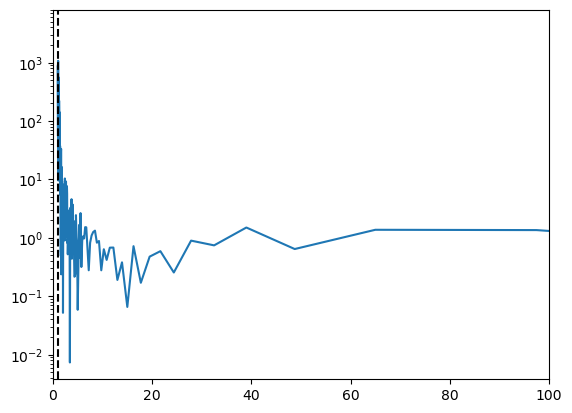

In [34]:
n=len(ty)
print(n)
print(x)
fft = np.fft.fft(ty,n=len(ty))
print(fft.shape)
#frequency = np.fft.fftshift(np.fft.fftfreq(n,posi))
frequency = np.fft.fftfreq(n,0.5)
freq_shift = np.fft.fftshift(frequency)
ps_y = np.abs(fft)**2
#frequency = np.linspace(0, x/2, len(ps_y))
plt.figure(1)
plt.clf()
plt.semilogy(frequency**-1, ps_y)
plt.xlim([0,100])
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')

plt.figure(2)
plt.clf()
plt.semilogy(frequency**-1,ps_y)
plt.xlim([0,100])
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlim(0,100)

plt.figure(3)
plt.clf()
plt.semilogy(freq_shift**-1,ps_y)
plt.xlim([0,100])
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
#plt.xscale('log')
plt.xlim(0,100)

## Direction en quasi Y (column)

(390, 167)
(390,)
167
(167,)


/tmp/ipykernel_18671/850949897.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency_snow**-1, ps_snow)


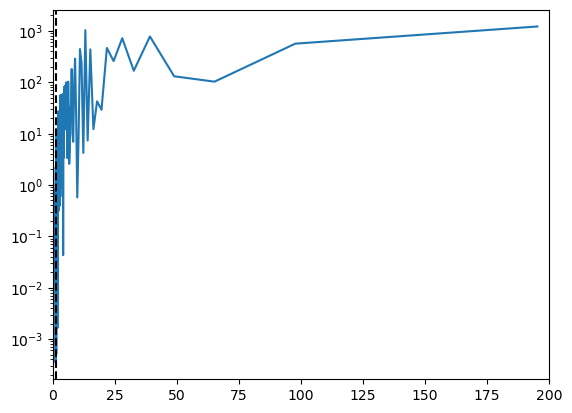

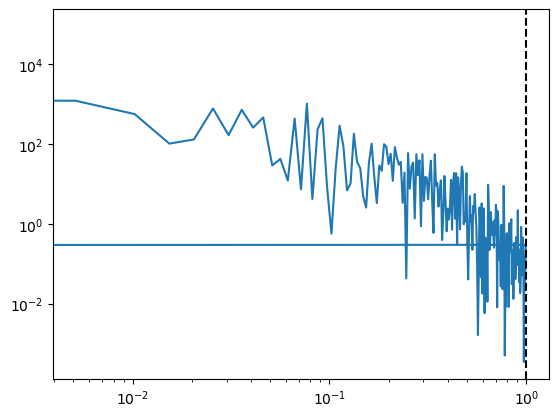

In [61]:
np.apply_along_axis(np.fft.fft, 0, cropped)
fft = np.apply_along_axis(np.fft.fft, 0, cropped)
print(fft.shape)
fft_y = np.median(fft, axis = 1)
print(fft_y.shape)
print(len(ps_y))
n=fft_y.size
frequency_snow = np.fft.fftfreq(n,x)
ps_snow = np.abs(fft_y)**2
#frequency = np.linspace(0, 0.5/2, len(ps_y))
print(ps_y.shape)
plt.figure(1)
plt.clf()
plt.semilogy(frequency_snow**-1, ps_snow)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xlim(0,200)

plt.figure(2)
plt.clf()
plt.semilogy(frequency_snow, ps_snow)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
#plt.xlim(0,200)

## Direction en quasi x (row)

(390, 167)
(167,)


/tmp/ipykernel_18671/2738578730.py:11: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_y)
/tmp/ipykernel_18671/2738578730.py:17: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1,ps_y)


(0.0, 50.0)

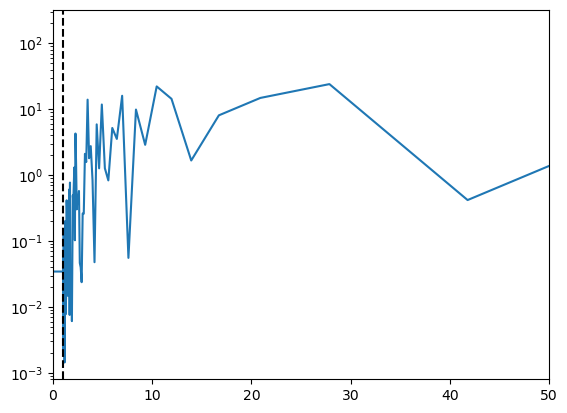

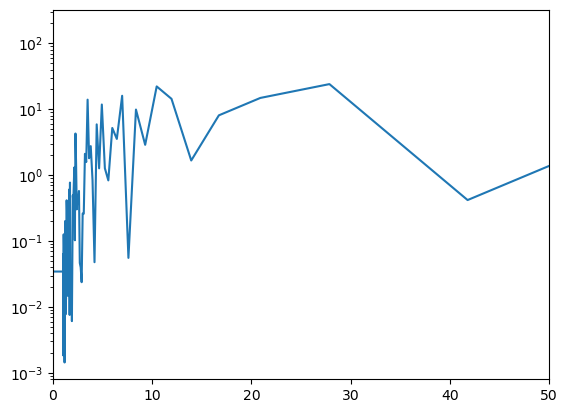

In [36]:

fft = np.apply_along_axis(np.fft.fft, 1, cropped)
print(fft.shape)
fft_y = np.median(fft, axis = 0)
print(fft_y.shape)
n=fft_y.size
frequency = np.fft.fftfreq(n,x)
ps_y = np.abs(fft_y)**2
#frequency = np.linspace(0, x/2, len(ps_y))
plt.figure(1)
plt.clf()
plt.semilogy(frequency**-1, ps_y)
plt.xlim(0,50)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')

plt.figure(2)
plt.clf()
plt.semilogy(frequency**-1,ps_y)
plt.xlim(0,50)

# Zone meloche

In [37]:
import numpy as np

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof


In [38]:
print(cropped.shape)
fft_2d = np.fft.fft2(cropped)

#fft_2d = fft.rfft2(arr)
#plt.imshow(np.log(abs(fft_2d)))
#plt.show

#plt.imshow(fft_2d)

fft_omni1d = azimuthalAverage(fft_2d)
frequency = np.fft.fftfreq(len(ps1D),x)
ps1D = np.abs(fft_omni1d)**2
# Now plot up both
plt.figure(1)
plt.clf()
plt.imshow(cropped, cmap= 'viridis')
plt.colorbar()

plt.figure(2)
plt.clf()
plt.imshow(np.log(power_spec))
plt.colorbar()

print(res[0])

plt.figure(3)
plt.clf()
plt.semilogy(frequency**-1, ps1D )
#plt.semilogy(np.log(frequency), np.log(psd1D) )
plt.xlabel('Distance m')
plt.ylabel('Power Spectrum')
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xlim(0,60)


plt.figure(4)
plt.clf()
plt.semilogy(frequency**-1, ps1D )
#plt.semilogy(np.log(frequency), np.log(psd1D) )
plt.xlabel('Distance m')
plt.ylabel('Power Spectrum')
plt.axvline(x=1.35, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlim(0,60)

(390, 167)


/home/francis/anaconda3/envs/geo71021/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  return bound(*args, **kwds)


NameError: name 'ps1D' is not defined

# Comparaison avec le TPI

resolution  0.1
upscale_factor 0.2
(1, 607, 493)
(0.5006085192692596, -0.5006589785826788)


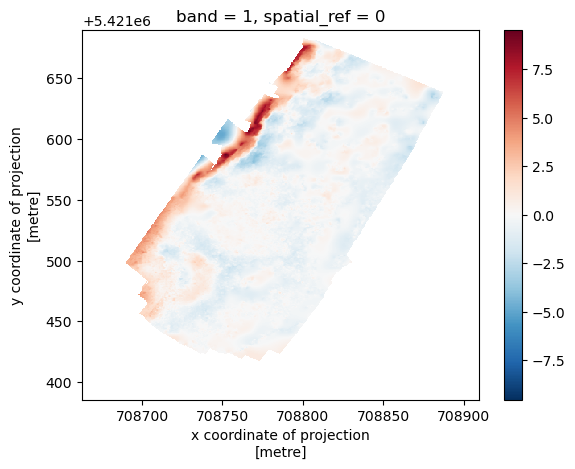

In [62]:
#raster = rasterio.open('/home/francis/Documents/programmation/Qgis/terrain_analysis/DTM_EP.tif',masked=True)
xdr = rio.open_rasterio('/home/francis/Documents/programmation/Qgis/terrain_analysis/TPI/TPI_EP.sdat',masked = True)
res = xdr.rio.resolution()
# resample data to target shape
print('resolution ',res[0])
upscale_factor = res[0]/0.5 #on s'en va vers une résolution de 0.5m
print('upscale_factor',upscale_factor)
new_width = int(xdr.rio.width * upscale_factor)
new_height = int(xdr.rio.height * upscale_factor)

xdr_resamp = xdr.rio.reproject(xdr.rio.crs, shape = (new_height, new_width), resampling = Resampling.bilinear)
print(xdr_resamp.shape)
print(xdr_resamp.rio.resolution())
xdr_resamp.plot()
res = xdr_resamp.rio.resolution()
x = res[0]
y = res[1]

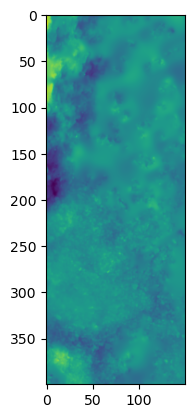

In [63]:
arr = np.array(xdr_resamp[0])
#arr=arr.astype('float')
#arr[arr < 0] = 0
arr[np.isnan(arr)] = 0
r_arr = ndimage.rotate(arr,25)
cropped= r_arr[120:520, 275:425]
plt.imshow(cropped, cmap= 'viridis')

(400, 150)
(400,)
167
(167,)


/tmp/ipykernel_18671/3539188732.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_tpi)


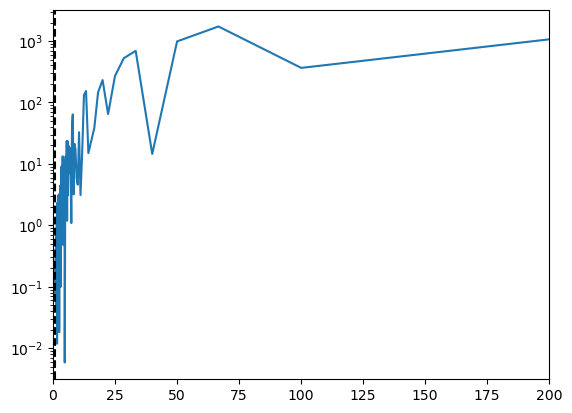

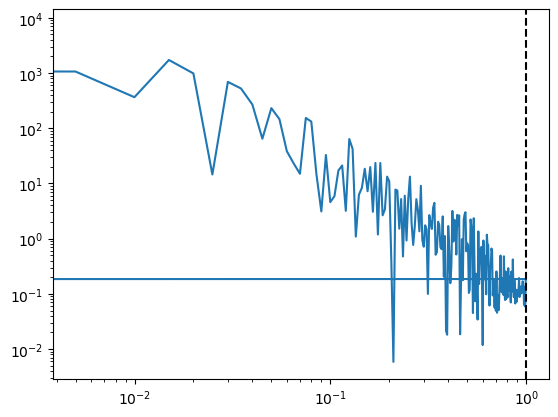

In [64]:
np.apply_along_axis(np.fft.fft, 0, cropped)
fft = np.apply_along_axis(np.fft.fft, 0, cropped)
print(fft.shape)
fft_y = np.median(fft, axis = 1)
print(fft_y.shape)
print(len(ps_y))
n=fft_y.size
frequency = np.fft.fftfreq(n,x)
ps_tpi = np.abs(fft_y)**2
#frequency = np.linspace(0, 0.5/2, len(ps_y))
print(ps_y.shape)
plt.figure(1)
plt.clf()
plt.semilogy(frequency**-1, ps_tpi)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xlim(0,200)

plt.figure(2)
plt.clf()
plt.semilogy(frequency, ps_tpi)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
#plt.xlim(0,200)

resolution  0.023250099886917883
upscale_factor 0.046500199773835765
(1, 607, 493)
(0.5004666578872813, -0.5005091566751173)


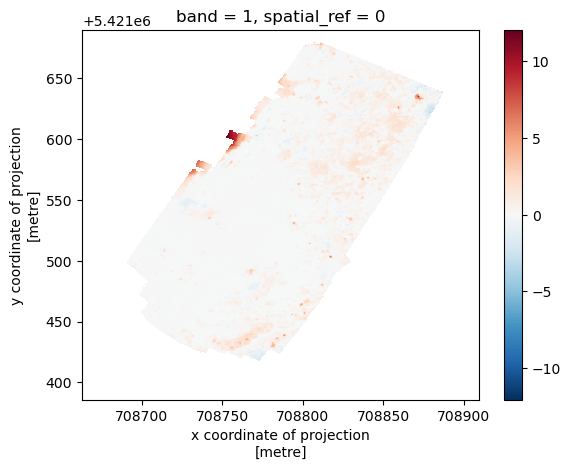

In [65]:
#raster = rasterio.open('/home/francis/Documents/programmation/Qgis/terrain_analysis/DTM_EP.tif',masked=True)
xdr = rio.open_rasterio('/home/francis/Documents/programmation/Qgis/terrain_analysis/canopy/canopy_EP.tif',masked = True)
res = xdr.rio.resolution()
# resample data to target shape
print('resolution ',res[0])
upscale_factor = res[0]/0.5 #on s'en va vers une résolution de 0.5m
print('upscale_factor',upscale_factor)
new_width = int(xdr.rio.width * upscale_factor)
new_height = int(xdr.rio.height * upscale_factor)

xdr_resamp = xdr.rio.reproject(xdr.rio.crs, shape = (new_height, new_width), resampling = Resampling.bilinear)
print(xdr_resamp.shape)
print(xdr_resamp.rio.resolution())
xdr_resamp.plot()
res = xdr_resamp.rio.resolution()
x = res[0]
y = res[1]

[[ 2.21871994e-02  1.52840950e-02 -7.63383647e-03 ... -1.43311862e-02
   4.19595279e-03 -1.89153086e-02]
 [ 2.60634683e-02  8.12166277e-03  1.54449735e-02 ...  1.50207337e-02
   1.08221717e-01  6.92138041e-04]
 [ 1.55049441e-02  7.71061284e-03  9.51373670e-03 ... -1.44645674e-02
   5.97881898e-03  5.41026844e-03]
 ...
 [-3.66345700e-03 -1.02155260e-03 -1.97809626e-04 ...  2.13252963e-03
   2.66545074e-04 -6.56644334e-05]
 [ 2.26452568e-04  7.22624653e-04 -2.10073540e-06 ... -8.38371366e-03
  -4.45423601e-03  4.69437847e-03]
 [ 4.86546378e-05 -2.24254763e-04  9.62397971e-05 ...  7.82723725e-02
   1.20578036e-01  1.81183025e-01]]


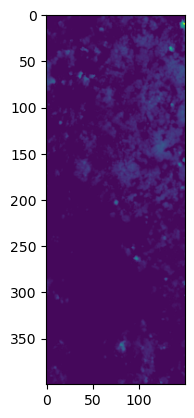

In [66]:
arr = np.array(xdr_resamp[0])
#arr=arr.astype('float')
arr[arr < 0] = 0
arr[np.isnan(arr)] = 0
r_arr = ndimage.rotate(arr,25)
cropped= r_arr[120:520, 275:425]
plt.imshow(cropped, cmap= 'viridis')
print(cropped)

(400, 150)
(400,)
167
(167,)


/tmp/ipykernel_18671/1713159889.py:14: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_canopy)


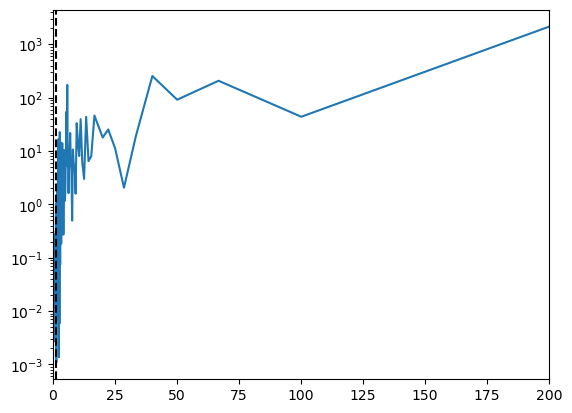

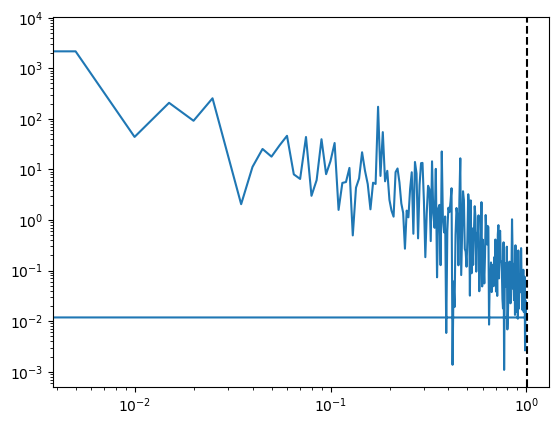

In [67]:
np.apply_along_axis(np.fft.fft, 0, cropped)
fft = np.apply_along_axis(np.fft.fft, 0, cropped)
print(fft.shape)
fft_y = np.median(fft, axis = 1)
print(fft_y.shape)
print(len(ps_y))
n=fft_y.size
frequency = np.fft.fftfreq(n,x)
ps_canopy = np.abs(fft_y)**2
#frequency = np.linspace(0, 0.5/2, len(ps_y))
print(ps_y.shape)
plt.figure(1)
plt.clf()
plt.semilogy(frequency**-1, ps_canopy)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xlim(0,200)

plt.figure(2)
plt.clf()
plt.semilogy(frequency, ps_canopy)
plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
#plt.xlim(0,200)

## Scaling properties 
L'analyse spectral et le théorême de Parseval nous donne le power spectrum.

Le power spectrum nous dit que l'intégral du signal nous donne la puissance sur signal...

Dans notre cas, on peut voir l'ensemble du signal et l'important de chaque fréquence (échelle) sur la variance totale de notre processus ou variable exploratoire.

Un outil indispensable du géographe!!

On peut également apercevoir une rupture d'échelle autour de 10 m (scale break) entre nos haute et basse fréquence.... ou small-scale et longue-scale.

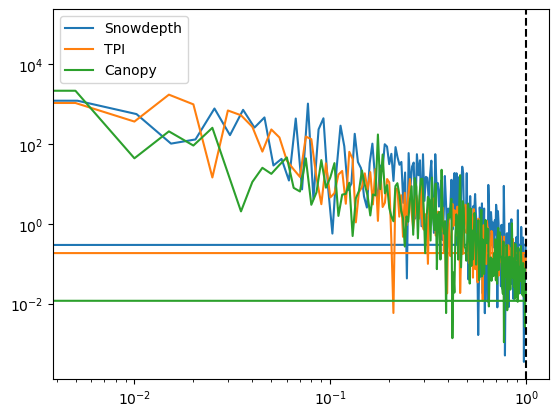

In [68]:
plt.semilogy(frequency_snow, ps_snow, label = 'Snowdepth')
plt.semilogy(frequency, ps_tpi, label = 'TPI')
plt.semilogy(frequency, ps_canopy, label = 'Canopy')

plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.legend()

/tmp/ipykernel_18671/3396740144.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency_snow**-1, ps_snow, label = 'Snowdepth')
/tmp/ipykernel_18671/3396740144.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_tpi, label = 'TPI')
/tmp/ipykernel_18671/3396740144.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  plt.semilogy(frequency**-1, ps_canopy, label = 'Canopy')


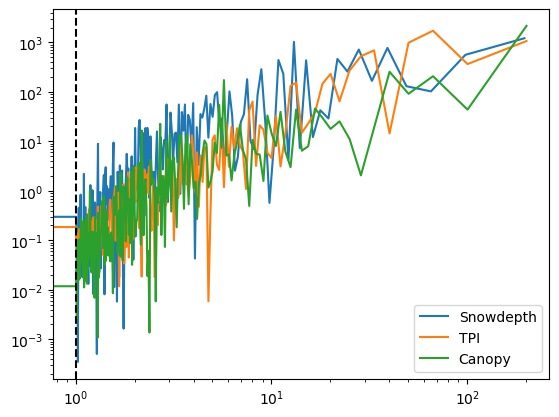

In [69]:
plt.semilogy(frequency_snow**-1, ps_snow, label = 'Snowdepth')
plt.semilogy(frequency**-1, ps_tpi, label = 'TPI')
plt.semilogy(frequency**-1, ps_canopy, label = 'Canopy')

plt.axvline(x=x*2, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.legend()